<a href="https://colab.research.google.com/github/nedokormysh/GB_pred-diag/blob/lesson_2_imbalanced_class/GB_pred%26diag_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Условие**

https://archive.ics.uci.edu/dataset/206/relative+location+of+ct+slices+on+axial+axis
C этим датасетом будем работать на уроке.

ДЗ - на этом же датасете выполнить задачу классификации.
Или же ДЗ опционально выполнить классификацию https://archive.ics.uci.edu/dataset/174/parkinsons

In [ ]:
!pip install catboost -q

In [ ]:
RND_STATE = 7575

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
                        recall_score, f1_score, log_loss, confusion_matrix, \
                  classification_report, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, \
                       LabelEncoder, label_binarize

from typing import List, Optional, Tuple, Union

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_metrics(y_test, y_pred, y_score, name):
    """Вывод метрик для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

# Загрузка данных

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons = fetch_ucirepo(id=174)

# data (as pandas dataframes)
X = parkinsons.data.features
y = parkinsons.data.targets

# # metadata
# print(parkinsons.metadata)

# # variable information
# print(parkinsons.variables)


# Краткий анализ данных

Датасет содержит биомедицинские измерения голоса у 31 человека, 23 из которых страдают болезнью Паркинсона (БП). Каждый столбец в таблице соответствует конкретному измерению голоса, а каждая строка - одной из 195 голосовых записей этих людей ("name" колонка). Главная цель данных - отличить здоровых людей от тех, у кого БП, в соответствии с колонкой "status", которая устанавливается на 0 для здоровых и 1 для БП.

## Целевая переменная

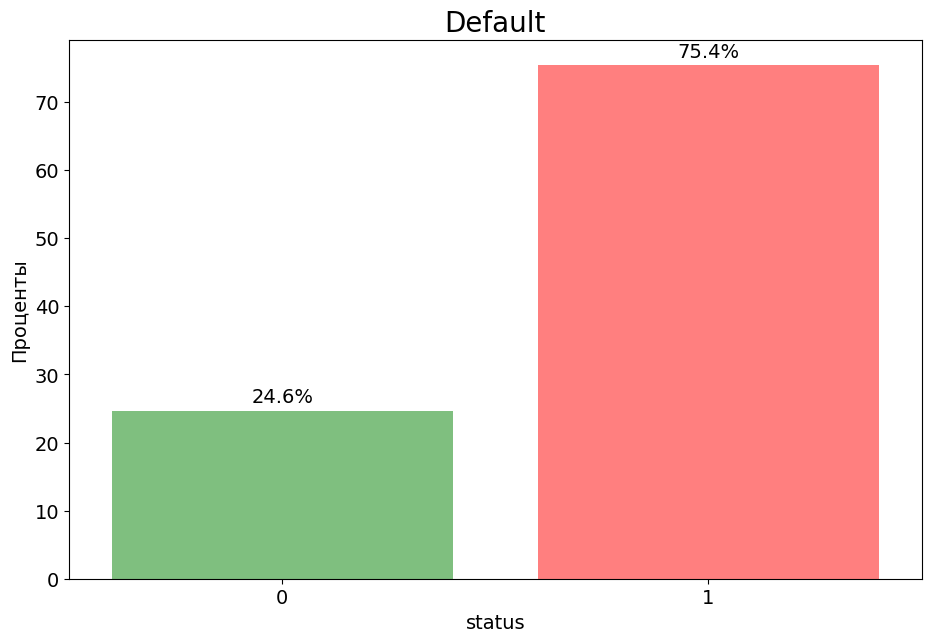

In [ ]:
norm_target = y['status'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
norm_target.columns = ['status', 'percent']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x='status', y='percent', data=norm_target, alpha=0.5)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14)

colors = ['g', 'r']
for i, p in enumerate(ax.patches):
    p.set_facecolor(colors[i % len(colors)])

plt.title('Default', fontsize=20)
plt.xlabel('status', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Выводы:**
- задача классификации
- в датасете присутствует дисбаланс классов, при обучении модели это стоит учитывать

## Датасет признаков

In [ ]:
X.sample(3)

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
9,95.056,120.103,91.226,0.00532,0.00532,0.00268,0.00332,0.00803,0.02838,0.02838,...,0.02444,0.04324,0.01022,21.862,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362
97,125.036,143.946,116.187,0.01280,0.01280,0.00743,0.00623,0.02228,0.03886,0.03886,...,0.03088,0.06406,0.08151,15.338,0.629574,0.714485,-4.020042,0.265315,2.671825,0.340623
89,179.711,225.930,144.878,0.00709,0.00709,0.00391,0.00419,0.01172,0.04313,0.04313,...,0.03455,0.06892,0.07223,11.866,0.590951,0.745526,-4.379411,0.375531,3.671155,0.332086


размер датасета

In [ ]:
X.shape

(195, 22)

датасет мал

общая информация

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MDVP:Fo       195 non-null    float64
 1   MDVP:Fhi      195 non-null    float64
 2   MDVP:Flo      195 non-null    float64
 3   MDVP:Jitter   195 non-null    float64
 4   MDVP:Jitter   195 non-null    float64
 5   MDVP:RAP      195 non-null    float64
 6   MDVP:PPQ      195 non-null    float64
 7   Jitter:DDP    195 non-null    float64
 8   MDVP:Shimmer  195 non-null    float64
 9   MDVP:Shimmer  195 non-null    float64
 10  Shimmer:APQ3  195 non-null    float64
 11  Shimmer:APQ5  195 non-null    float64
 12  MDVP:APQ      195 non-null    float64
 13  Shimmer:DDA   195 non-null    float64
 14  NHR           195 non-null    float64
 15  HNR           195 non-null    float64
 16  RPDE          195 non-null    float64
 17  DFA           195 non-null    float64
 18  spread1       195 non-null    

Все признаки - числовые

In [ ]:
X.isna().any().any()

False

У нас нет пропусков в данных

In [ ]:
X.duplicated().any()

False

Дублей в данных нет

## Распределения признаков

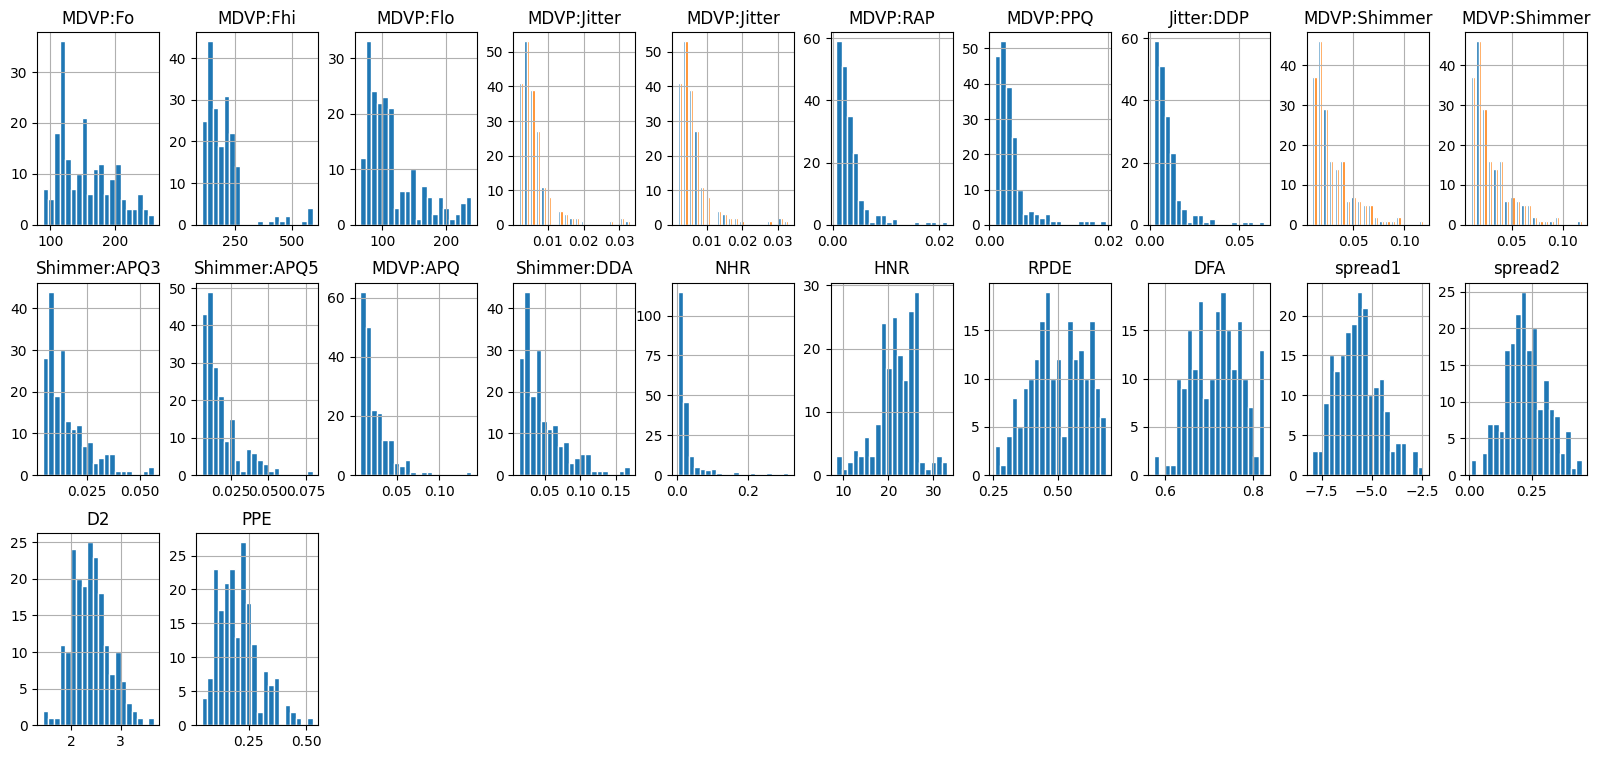

In [ ]:
X.hist(figsize=(20,9), layout=(-1,10), bins=20, edgecolor='w');

Бинарных признаков нет.

Числовые характеристики распределения

In [ ]:
X.describe()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.006220,0.003306,0.003446,0.009920,0.029709,0.029709,...,0.024081,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.004848,0.002968,0.002759,0.008903,0.018857,0.018857,...,0.016947,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.001680,0.000680,0.000920,0.002040,0.009540,0.009540,...,0.007190,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.003460,0.001660,0.001860,0.004985,0.016505,0.016505,...,0.013080,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.004940,0.002500,0.002690,0.007490,0.022970,0.022970,...,0.018260,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.007365,0.003835,0.003955,0.011505,0.037885,0.037885,...,0.029400,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.033160,0.021440,0.019580,0.064330,0.119080,0.119080,...,0.137780,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Потребуется нормализация признаков

<Axes: >

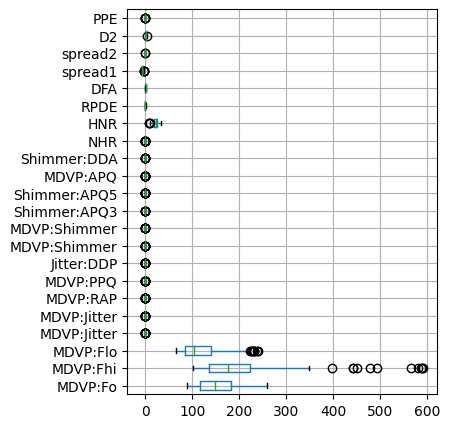

In [ ]:
X.boxplot(vert=False, figsize=(4, 5))

Ещё раз убедились, что придётся нормализовать данные. В некоторых признаках есть выбросы.

Рассмотрим матрицу корреляции

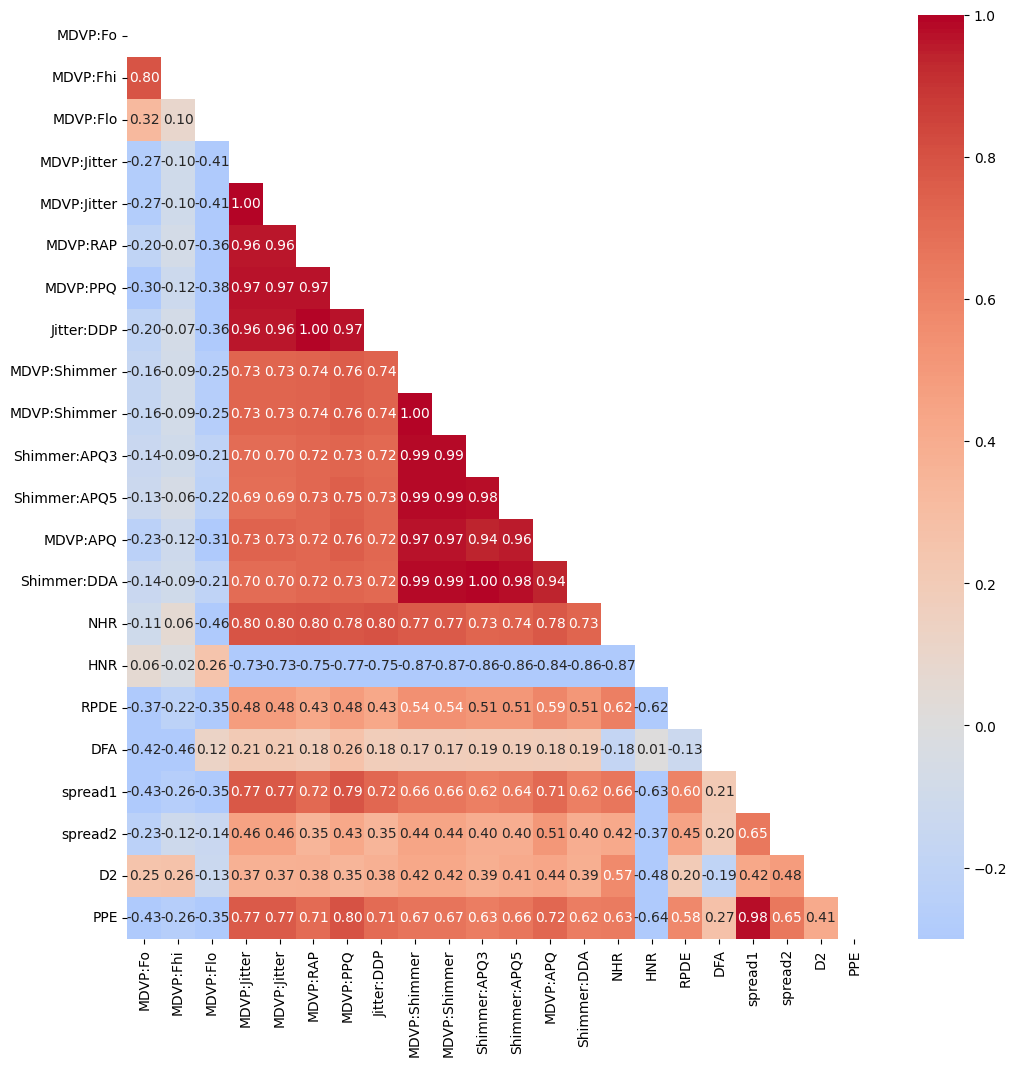

In [ ]:
matrix = np.triu(X.corr(method='spearman'))

plt.figure(figsize=(12, 12))

sns.heatmap(X.corr(method='spearman'), annot=True,
            fmt='.2f', vmin=-0.3, center=0, cmap='coolwarm', mask=matrix);

Удалим признаки с корреляцией выше 0.8

In [ ]:
corr_df = X.corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool) & (corr_df > .8))
tri_df = corr_df.mask(mask)

to_drop = [c for c in tri_df.columns if any(tri_df[c] > .8)]

reduced_X = X.drop(to_drop, axis=1)

In [ ]:
reduced_X.shape

(195, 11)

# Модели

In [ ]:
y = y["status"]

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(reduced_X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RND_STATE,
                                                    shuffle=True,
                                                    # stratify=y
                                                    )

## Логистическая регрессия

### без балансировки веса

Вообще корректировка количества объектов в классах для логистической регрессии, как мне кажется, нарушает смысл обучения логистической регрессии. - она уже не будет показывать вероятности классов.

Но рассмотрим разные варианты.

In [ ]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            # class_weight='balanced'
                                            ))])

pipe_lr_base.fit(X_train, y_train)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.90      0.93      0.92        30

    accuracy                           0.87        39
   macro avg       0.83      0.80      0.81        39
weighted avg       0.87      0.87      0.87        39



In [ ]:
metrics = get_metrics(y_test, y_pred, y_score, name='Log_Reg_Baseline')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Log_Reg_Baseline,0.871795,0.881481,0.903226,0.933333,0.918033,0.325355


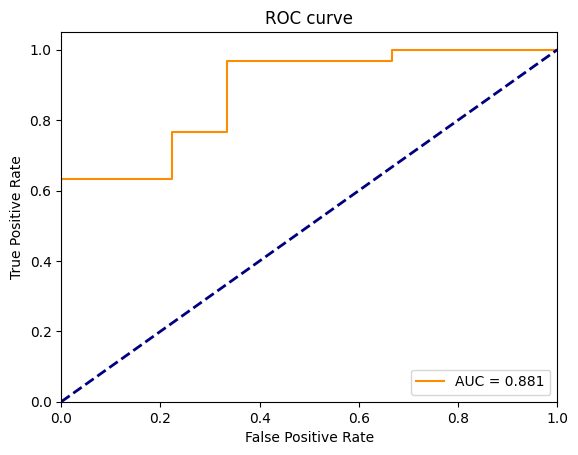

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Выводы:**
- модель неплохо справляется с задачей, но и нельзя сказать, что хорошо.

### c балансировкой веса

In [ ]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            class_weight='balanced'
                                            ))])

pipe_lr_base.fit(X_train, y_train)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.92      0.77      0.84        30

    accuracy                           0.77        39
   macro avg       0.71      0.77      0.72        39
weighted avg       0.82      0.77      0.78        39



In [ ]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_ClassWeight')])
# metrics

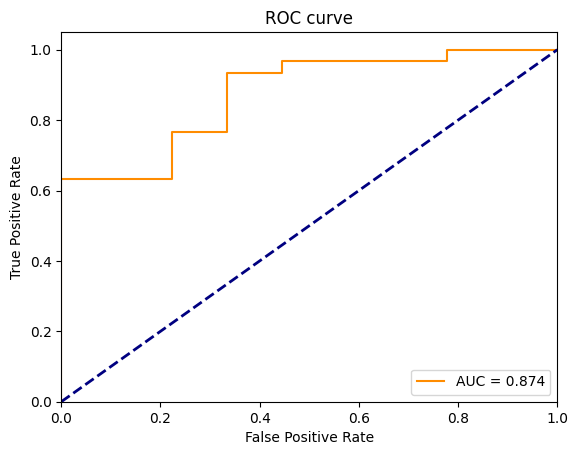

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Выводы:**
- Результаты стали хуже. Сильно упала precision в нулевом классе.

### oversampling

дублирование примеров наименьшего класса

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_train.shape

(156, 11)

In [ ]:
X_over.shape

(234, 11)

In [ ]:
y_train.value_counts()

status
1    117
0     39
Name: count, dtype: int64

In [ ]:
y_over.value_counts()

status
1    117
0    117
Name: count, dtype: int64

In [ ]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                                    max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_over, y_over)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.67      0.52         9
           1       0.88      0.73      0.80        30

    accuracy                           0.72        39
   macro avg       0.65      0.70      0.66        39
weighted avg       0.78      0.72      0.74        39



In [ ]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_OverSampling')])
# metrics

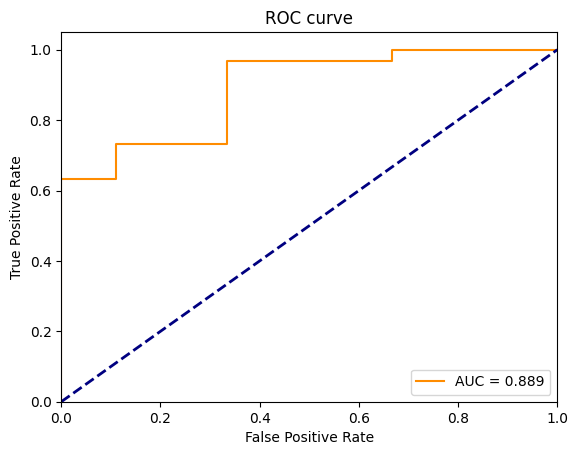

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Выводы:**
- precision для нулевого класса ещё меньше, чем в предыдущих моделях

### undersampling

дублирование примеров мажоритарного (наибольшего) класса

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=1.0) #sampling_strategy = majority
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [ ]:
X_under.shape

(78, 11)

In [ ]:
X_train.shape

(156, 11)

In [ ]:
y_under.value_counts()

status
0    39
1    39
Name: count, dtype: int64

In [ ]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                                    max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_under, y_under)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.78      0.56         9
           1       0.91      0.70      0.79        30

    accuracy                           0.72        39
   macro avg       0.68      0.74      0.68        39
weighted avg       0.80      0.72      0.74        39



In [ ]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_UnderSampling')])
# metrics

**Выводы:**
- модель максимально близка к результат логистической регрессии с использованием вычисления весов для каждого класса, встроенного в sklern модель

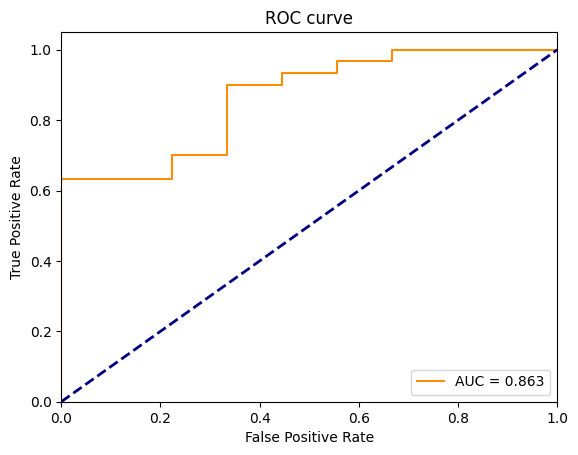

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

status
1    117
0     39
Name: count, dtype: int64

In [ ]:
y_smote.value_counts()

status
1    117
0    117
Name: count, dtype: int64

In [ ]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                                    max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_smote, y_smote)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.92      0.77      0.84        30

    accuracy                           0.77        39
   macro avg       0.71      0.77      0.72        39
weighted avg       0.82      0.77      0.78        39



In [ ]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_SMOTE')])
# metrics

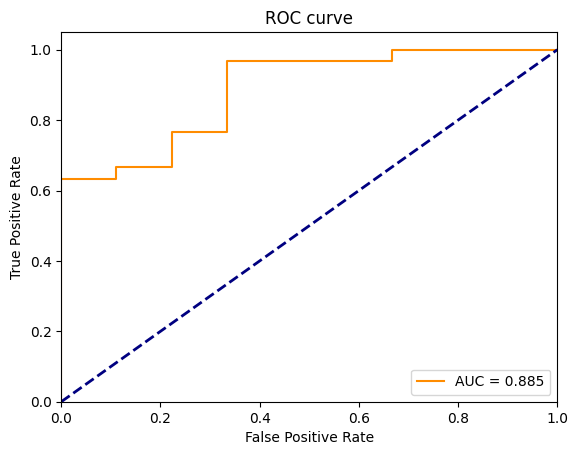

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Выводы:**
- опять же понижена precision нулевого класса относительно бейслайн модели

## Catboost

In [ ]:
pipe_catboost = Pipeline([('scaler', StandardScaler()),
                         ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            # auto_class_weights='Balanced',
                                            verbose=False))])

pipe_catboost.fit(X_train, y_train)

y_pred = pipe_catboost.predict(X_test)
y_score = pipe_catboost.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.93      0.97        30

    accuracy                           0.95        39
   macro avg       0.91      0.97      0.93        39
weighted avg       0.96      0.95      0.95        39



In [ ]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Catboost_ClassWeight')])
# metrics

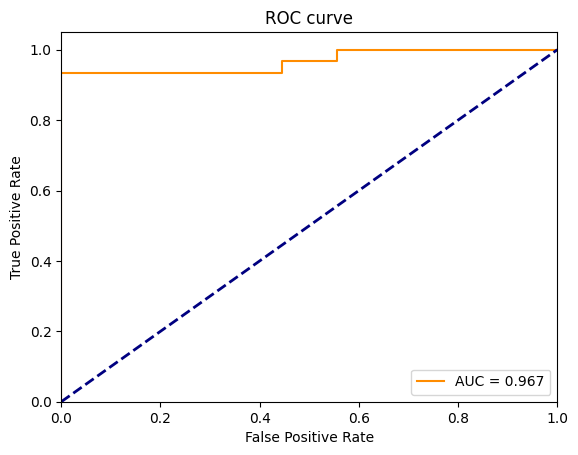

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Выводы:**
- модель явно лучше по всем метрикам, чем даёт логистическая регрессия

## MLP Classifier

In [ ]:
pipe_mlp = Pipeline([('scaler', StandardScaler()),
                     ('clf', MLPClassifier(random_state=RND_STATE,
                                           solver='adam',
                                           verbose=False))])

pipe_mlp.fit(X_train, y_train)

y_pred = pipe_mlp.predict(X_test)
y_score = pipe_mlp.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.97      0.97      0.97        30

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



In [ ]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='MLP_Baseline')])
# metrics

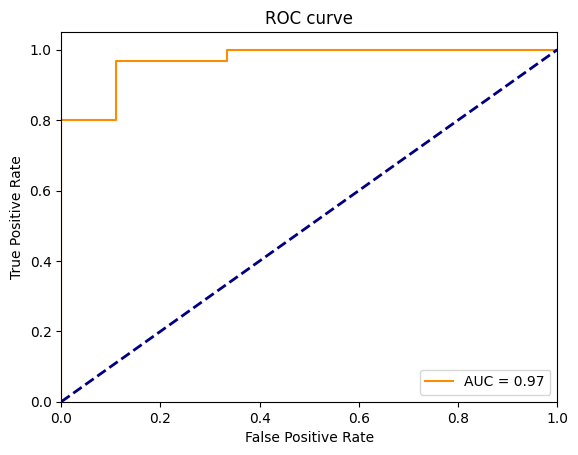

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

# Результаты

In [ ]:
metrics.set_index('model', inplace=True)
# Сортировка по столбцу ROC_AUC
sorted_metrics = metrics.sort_values(by='ROC_AUC', ascending=False)
round(sorted_metrics, 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
MLP_Baseline,0.94872,0.97037,0.96667,0.96667,0.96667,0.21344
Catboost_ClassWeight,0.94872,0.96667,1.00000,0.93333,0.96552,0.18799
Log_Reg_OverSampling,0.71795,0.88889,0.88000,0.73333,0.80000,0.41487
Log_Reg_SMOTE,0.76923,0.88519,0.92000,0.76667,0.83636,0.42263
Log_Reg_Baseline,0.87179,0.88148,0.90323,0.93333,0.91803,0.32535
Log_Reg_ClassWeight,0.76923,0.87407,0.92000,0.76667,0.83636,0.43055
Log_Reg_UnderSampling,0.71795,0.86296,0.91304,0.70000,0.79245,0.45208


**Выводы:**
- Многослойный перцептрон (MLP) в базовой конфигурации показывает лучшие результаты по всем метрикам, кроме logloss и precision, где он уступает Catboost_ClassWeight.
- Catboost_ClassWeight также показывает результаты, уступая лишь MLP_Baseline по некоторым метрикам, таким как точность (Accuracy) и F1-score.
- Если сравнивать только по ROC_AUC, то лучшим среди логистических регрессоров оказался классификатор с дублированием примеров наименьшего класса, впрочем SMOTE вариант показал очень близкие результаты. Возможно разные техники учёта несбалансированности датасета, давали бы улучшения, если бы было больше объектов.
- Модели отличались по порогу отнесения объектов к положительному классу. кривые roc_auc не совпали ни у одной модели.